# Fine-Tune VGG-Face weight to use it with own dataset

This is my experiment on VGG-Face pretrained model to see whether VGG-Face can classify faces that are not trained in its pre-trained model.

Based on this website: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
There are 4 quadrants that we can use as a guide for fine-tuning. In this experiment, I will try Quadrant 3 and Quadrant 4.

In [1]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape, GlobalAveragePooling2D
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


Set the batch size to 4 because the number of images that I collect is not much

In [2]:
batch_size = 4
nepochs = 20
nrow = 224
ncol = 224

In [3]:
#Function to plot graph of accuracy and loss
def plot_graph():
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])  
    
    plt.figure()
    
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

In [4]:
#Function that contains the layers that I want to combine with the original model
def modify_last_layer():
    last_layer = model.layers[-8].output
    #last_layer = model.get_layer('max_pooling2d_5').output

    x = Flatten()(last_layer)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_class, activation='softmax')(x)
    
    return x

In [5]:
#Function that have all layers required to load the VGG-Face weights
def VGG_Face_weights():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))

    #got this model from the following link
    #https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
    model.load_weights('vgg_face_weights.h5')
    
    return model

In [6]:
model = VGG_Face_weights()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [7]:
train_data_dir = 'data/train'
#preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

#magically retrieves images and classes
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(nrow,ncol),
    batch_size=batch_size,
    class_mode='sparse')

validation_data_dir = 'data/validation'
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(nrow,ncol),
    batch_size=batch_size,
    class_mode='sparse')

#To retrieve number of class dynamically
num_class = len(train_generator.class_indices)

Found 30 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


# Quadrant 4 case

Here, I want to test Quadrant 4 case first. So, I freeze all layers except 4 last (top) layers. I did not freeze them because I want to train them

In [8]:
x = modify_last_layer()
#new model
custom_model = Model(inputs=model.input, outputs=x)
for layer in custom_model.layers[:-4]:
    layer.trainable = False

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
__________

Notice that in the listed layers above that Non-trainable params has changed from 0 in the original model to some value in this model.

I choose to use sparse_categorical as the loss function because this problem involves more than 2 classes. 2 classes problem can use binary_crossentropy. 
I could choose categorical_crossentropy too but I don't want to do one-hot-encoding so no need

In [9]:
custom_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

steps_per_epoch = train_generator.n // batch_size
validation_steps =  validation_generator.n // batch_size

#train
history = custom_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/20
7/7 [==============================] - 2s 269ms/step - loss: 1.0997 - acc: 0.3606 - val_loss: 1.0930 - val_acc: 0.3889
Epoch 2/20
7/7 [==============================] - 0s 62ms/step - loss: 1.0828 - acc: 0.4639 - val_loss: 1.1011 - val_acc: 0.3889
Epoch 3/20
7/7 [==============================] - 0s 52ms/step - loss: 1.1023 - acc: 0.3558 - val_loss: 1.0898 - val_acc: 0.5000
Epoch 4/20
7/7 [==============================] - 0s 61ms/step - loss: 1.0785 - acc: 0.4643 - val_loss: 1.0912 - val_acc: 0.3889
Epoch 5/20
7/7 [==============================] - 0s 51ms/step - loss: 1.0768 - acc: 0.5000 - val_loss: 1.0761 - val_acc: 0.6111
Epoch 6/20
7/7 [==============================] - 0s 52ms/step - loss: 1.0441 - acc: 0.7163 - val_loss: 1.0746 - val_acc: 0.5556
Epoch 7/20
7/7 [==============================] - 0s 47ms/step - loss: 1.0653 - acc: 0.5729 - val_loss: 1.0564 - val_acc: 0.5556
Epoch 8/20
7/7 [==============================] - 0s 43ms/step - loss: 1.0379 - acc: 0.6786 - va

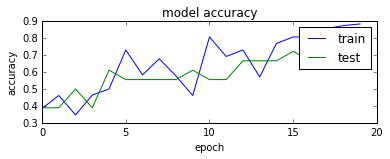

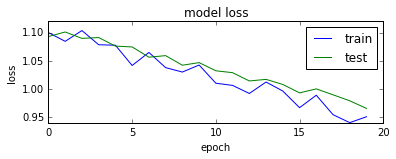

In [10]:
plot_graph()

In [11]:
#save the model
custom_model.save('q4_face_model.h5')

### Comments

-  Validation accuracy for first model is around 0.8
-  The graph shows that accuracy for both train and validation keep increasing while loss for both train and validation keep decreasing. This could mean that increasing the number of epochs will improve the model

# Quadrant 3 case

# Freeze layer 0-4

In [12]:
model = VGG_Face_weights()
#model.summary()

x = modify_last_layer()

In [13]:
#new model
custom_model2 = Model(inputs=model.input, outputs=x)
for layer in custom_model2.layers[:5]:
    layer.trainable = False
    
custom_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [14]:
custom_model2.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

#nepochs = 30
history = custom_model2.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/20
7/7 [==============================] - 2s 277ms/step - loss: 1.0861 - acc: 0.4279 - val_loss: 1.0944 - val_acc: 0.5556
Epoch 2/20
7/7 [==============================] - 0s 64ms/step - loss: 1.0727 - acc: 0.4952 - val_loss: 1.0834 - val_acc: 0.6111
Epoch 3/20
7/7 [==============================] - 0s 64ms/step - loss: 1.0666 - acc: 0.5361 - val_loss: 1.0814 - val_acc: 0.5556
Epoch 4/20
7/7 [==============================] - 0s 70ms/step - loss: 1.0571 - acc: 0.5721 - val_loss: 1.0760 - val_acc: 0.6111
Epoch 5/20
7/7 [==============================] - 0s 68ms/step - loss: 1.0601 - acc: 0.5357 - val_loss: 1.0746 - val_acc: 0.5000
Epoch 6/20
7/7 [==============================] - 0s 71ms/step - loss: 1.0267 - acc: 0.7163 - val_loss: 1.0373 - val_acc: 0.6667
Epoch 7/20
7/7 [==============================] - 0s 65ms/step - loss: 1.0151 - acc: 0.7837 - val_loss: 1.0283 - val_acc: 0.7222
Epoch 8/20
7/7 [==============================] - 0s 62ms/step - loss: 0.9970 - acc: 0.7476 - va

In [15]:
#save the model
custom_model2.save('q3_face_model1.h5')

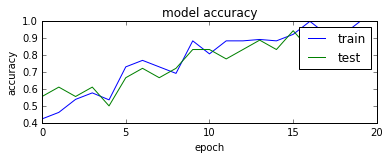

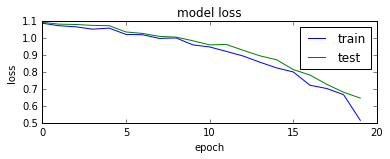

In [16]:
plot_graph()

### Comments

-  The validation accuracy is around 0.9 and it has lower validation loss compared to previous model
-  This model can be trained more but needs to be careful of overfitting

# Freeze layer 0-9

In [17]:
model = VGG_Face_weights()
#model.summary()

x = modify_last_layer()

In [18]:
#new model
custom_model3 = Model(inputs=model.input, outputs=x)
for layer in custom_model3.layers[:10]:
    layer.trainable = False
    
custom_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [19]:
custom_model3.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

#nepochs = 30
history = custom_model3.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/20
7/7 [==============================] - 1s 209ms/step - loss: 1.0810 - acc: 0.3918 - val_loss: 1.0739 - val_acc: 0.5556
Epoch 2/20
7/7 [==============================] - 0s 65ms/step - loss: 1.0938 - acc: 0.2885 - val_loss: 1.0593 - val_acc: 0.5556
Epoch 3/20
7/7 [==============================] - 0s 69ms/step - loss: 1.0594 - acc: 0.5000 - val_loss: 1.0461 - val_acc: 0.5556
Epoch 4/20
7/7 [==============================] - 0s 69ms/step - loss: 1.0826 - acc: 0.2885 - val_loss: 1.0569 - val_acc: 0.5556
Epoch 5/20
7/7 [==============================] - 0s 69ms/step - loss: 1.0439 - acc: 0.5673 - val_loss: 1.0426 - val_acc: 0.5000
Epoch 6/20
7/7 [==============================] - 0s 62ms/step - loss: 1.0266 - acc: 0.7188 - val_loss: 1.0373 - val_acc: 0.6111
Epoch 7/20
7/7 [==============================] - 0s 58ms/step - loss: 1.0378 - acc: 0.4643 - val_loss: 1.0172 - val_acc: 0.7778
Epoch 8/20
7/7 [==============================] - 0s 55ms/step - loss: 1.0057 - acc: 0.7476 - va

In [20]:
#save the model
custom_model3.save('q3_face_model2.h5')

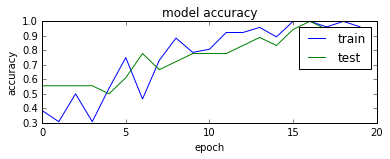

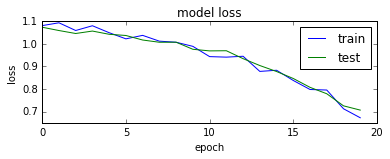

In [21]:
plot_graph()

## Comments

-  The validation accuracy is around 0.8 and it has higher validation loss compared to previous model
-  Just like previous model, it can be trained more but needs to be aware of overfitting

# Freeze layer 0-16

In [22]:
model = VGG_Face_weights()
#model.summary()

x = modify_last_layer()

In [23]:
#new model
custom_model4 = Model(inputs=model.input, outputs=x)
for layer in custom_model4.layers[:17]:
    layer.trainable = False
    
custom_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_40_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [24]:
custom_model4.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

#nepochs = 30
history = custom_model4.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/20
7/7 [==============================] - 1s 208ms/step - loss: 1.0823 - acc: 0.4639 - val_loss: 1.0907 - val_acc: 0.3889
Epoch 2/20
7/7 [==============================] - 0s 64ms/step - loss: 1.0954 - acc: 0.3606 - val_loss: 1.0812 - val_acc: 0.4444
Epoch 3/20
7/7 [==============================] - 0s 51ms/step - loss: 1.0806 - acc: 0.3606 - val_loss: 1.0800 - val_acc: 0.5000
Epoch 4/20
7/7 [==============================] - 0s 53ms/step - loss: 1.0742 - acc: 0.6755 - val_loss: 1.0764 - val_acc: 0.6111
Epoch 5/20
7/7 [==============================] - 0s 59ms/step - loss: 1.0559 - acc: 0.8214 - val_loss: 1.0605 - val_acc: 0.7222
Epoch 6/20
7/7 [==============================] - 0s 51ms/step - loss: 1.0453 - acc: 0.7476 - val_loss: 1.0514 - val_acc: 0.7778
Epoch 7/20
7/7 [==============================] - 0s 53ms/step - loss: 1.0428 - acc: 0.8918 - val_loss: 1.0465 - val_acc: 0.7778
Epoch 8/20
7/7 [==============================] - 0s 51ms/step - loss: 1.0150 - acc: 0.9639 - va

In [25]:
#save the model
custom_model4.save('q3_face_model3.h5')

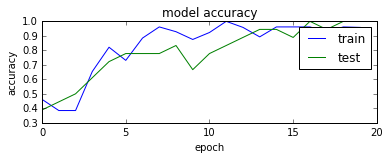

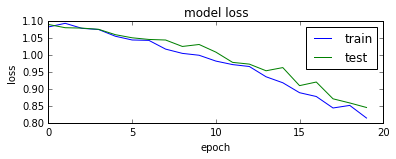

In [26]:
plot_graph()

### Comments

-  The validation accuracy is around 1.0 and it has higher validation loss compared to two previous model
-  This model also shows sign of going to be underfits (maybe). Notice that there is higher validation accuracy than training accuracy

# Test the model

Now, it's time to test all the models

In [27]:
#Function to test the model
def test_model(model):
    #can use train_generator.class_indices too
    #class_dictionary = train_generator.class_indices
    class_dictionary = validation_generator.class_indices
    
    inv_map = {v: k for k, v in class_dictionary.items()}
    print(inv_map)
    
    basedir = 'data/test/'
    for path in os.listdir(basedir):
        img = load_img(basedir+path,False,target_size=(nrow,ncol))
        imarr = img_to_array(img)
        imarr = imarr / 255 #important because in ImageDataGenerator we set rescale=1. / 255
        im_arr = np.expand_dims(imarr, axis=0)
        
        prob = model.predict(im_arr)
        pred = prob.argmax(axis=-1)
        
        #print(path, prob, pred)
        
        imID = pred[0]  
        label = inv_map[imID]
        
        print('image: {}, label: {}, probs: {}'.format(path, label, prob))
        
        plt.figure(figsize = (20,2))
        plt.imshow(imarr)
        plt.show()


{0: 'Chaeyoung', 1: 'Dahyun', 2: 'Tzuyu'}
image: 8.jpg, label: Dahyun, probs: [[0.2909202  0.45826015 0.25081962]]


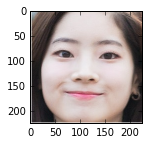

image: 7.jpg, label: Dahyun, probs: [[0.28502008 0.36179295 0.353187  ]]


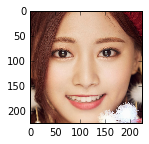

image: 10.jpg, label: Chaeyoung, probs: [[0.36707023 0.33093092 0.30199888]]


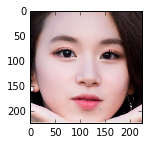

image: 11.jpg, label: Dahyun, probs: [[0.30330622 0.36560768 0.33108607]]


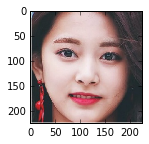

image: 1.jpg, label: Dahyun, probs: [[0.2563494  0.47935444 0.26429617]]


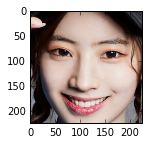

image: 5.jpg, label: Chaeyoung, probs: [[0.36482823 0.31018987 0.32498193]]


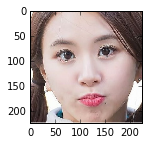

image: 2.jpg, label: Dahyun, probs: [[0.278116   0.4485539  0.27333018]]


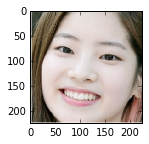

image: 6.jpg, label: Tzuyu, probs: [[0.31951228 0.32199085 0.3584969 ]]


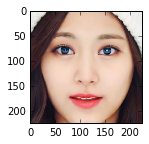

image: 4.jpg, label: Dahyun, probs: [[0.33357966 0.34964266 0.31677768]]


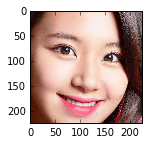

image: 12.jpg, label: Tzuyu, probs: [[0.30010712 0.3447404  0.35515252]]


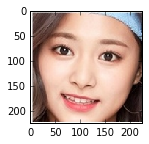

image: 9.jpg, label: Dahyun, probs: [[0.28711686 0.44363508 0.269248  ]]


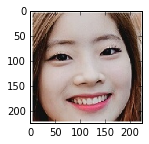

image: 3.jpg, label: Chaeyoung, probs: [[0.3686922 0.3177314 0.3135764]]


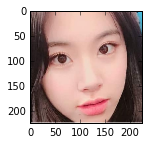

In [28]:
test_model(custom_model)

This model (quadrant4 model) has 9 out of 12 images correctly classified

{0: 'Chaeyoung', 1: 'Dahyun', 2: 'Tzuyu'}
image: 8.jpg, label: Dahyun, probs: [[0.11329239 0.7945406  0.09216707]]


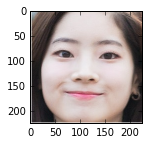

image: 7.jpg, label: Tzuyu, probs: [[0.22208235 0.22347313 0.55444455]]


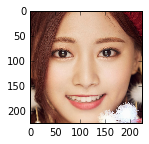

image: 10.jpg, label: Chaeyoung, probs: [[0.54063433 0.1233113  0.33605435]]


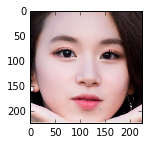

image: 11.jpg, label: Tzuyu, probs: [[0.28882566 0.26054147 0.45063284]]


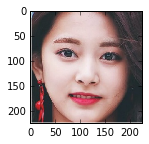

image: 1.jpg, label: Dahyun, probs: [[0.07883272 0.76184607 0.1593212 ]]


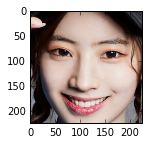

image: 5.jpg, label: Chaeyoung, probs: [[0.5110657  0.16823342 0.3207009 ]]


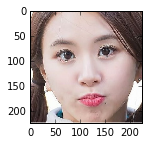

image: 2.jpg, label: Dahyun, probs: [[0.16004787 0.6802664  0.15968576]]


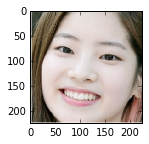

image: 6.jpg, label: Tzuyu, probs: [[0.32226953 0.1713332  0.5063973 ]]


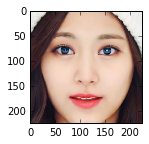

image: 4.jpg, label: Tzuyu, probs: [[0.34302884 0.23627208 0.4206991 ]]


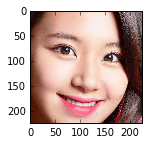

image: 12.jpg, label: Tzuyu, probs: [[0.22533424 0.16870813 0.6059576 ]]


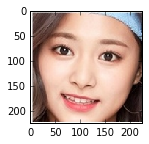

image: 9.jpg, label: Dahyun, probs: [[0.14983436 0.6948082  0.15535744]]


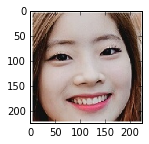

image: 3.jpg, label: Tzuyu, probs: [[0.40017802 0.17307316 0.4267489 ]]


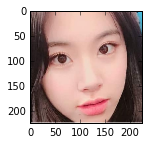

In [29]:
test_model(custom_model2)

This model (freeze 0-4 model) has 10 out of 12 images correctly classified

{0: 'Chaeyoung', 1: 'Dahyun', 2: 'Tzuyu'}
image: 8.jpg, label: Dahyun, probs: [[0.18142028 0.6799558  0.13862395]]


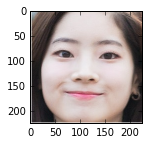

image: 7.jpg, label: Tzuyu, probs: [[0.23910186 0.28760526 0.47329283]]


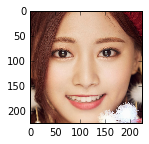

image: 10.jpg, label: Chaeyoung, probs: [[0.5502299  0.18166688 0.2681032 ]]


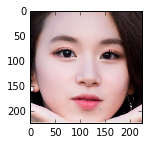

image: 11.jpg, label: Tzuyu, probs: [[0.34418502 0.21066432 0.44515067]]


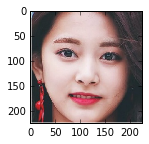

image: 1.jpg, label: Dahyun, probs: [[0.15999618 0.6526386  0.18736516]]


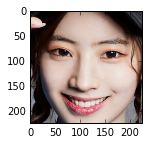

image: 5.jpg, label: Chaeyoung, probs: [[0.48203698 0.21123515 0.30672786]]


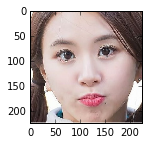

image: 2.jpg, label: Dahyun, probs: [[0.2183393  0.5848227  0.19683799]]


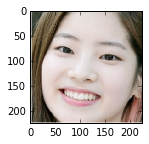

image: 6.jpg, label: Tzuyu, probs: [[0.39978877 0.18556932 0.41464186]]


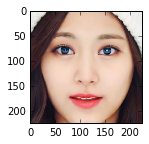

image: 4.jpg, label: Chaeyoung, probs: [[0.38911915 0.23871623 0.37216464]]


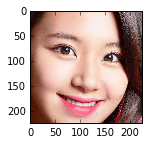

image: 12.jpg, label: Tzuyu, probs: [[0.29055178 0.18779235 0.52165586]]


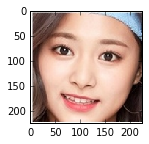

image: 9.jpg, label: Dahyun, probs: [[0.18682607 0.6727439  0.14042996]]


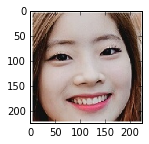

image: 3.jpg, label: Chaeyoung, probs: [[0.37663278 0.24733628 0.37603098]]


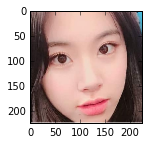

In [30]:
test_model(custom_model3)

This model (freeze 0-9 model) has all images correctly classified

{0: 'Chaeyoung', 1: 'Dahyun', 2: 'Tzuyu'}
image: 8.jpg, label: Dahyun, probs: [[0.21172887 0.5601341  0.22813706]]


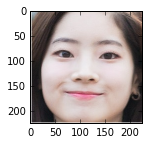

image: 7.jpg, label: Tzuyu, probs: [[0.28309405 0.29832715 0.41857877]]


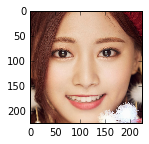

image: 10.jpg, label: Chaeyoung, probs: [[0.41504398 0.25013143 0.33482456]]


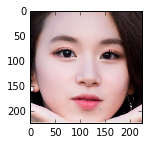

image: 11.jpg, label: Tzuyu, probs: [[0.2945989  0.3094845  0.39591655]]


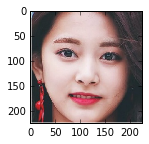

image: 1.jpg, label: Dahyun, probs: [[0.19057709 0.5438808  0.2655421 ]]


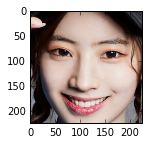

image: 5.jpg, label: Chaeyoung, probs: [[0.40509465 0.2544771  0.34042823]]


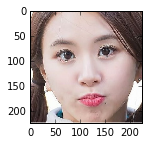

image: 2.jpg, label: Dahyun, probs: [[0.21875873 0.52827257 0.2529687 ]]


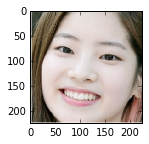

image: 6.jpg, label: Tzuyu, probs: [[0.34599146 0.22961497 0.4243936 ]]


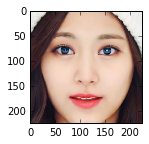

image: 4.jpg, label: Chaeyoung, probs: [[0.36067736 0.28245634 0.35686633]]


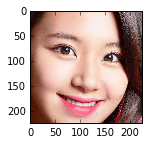

image: 12.jpg, label: Tzuyu, probs: [[0.28907862 0.25998247 0.45093894]]


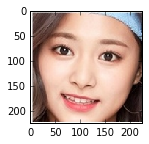

image: 9.jpg, label: Dahyun, probs: [[0.24850005 0.5029463  0.24855359]]


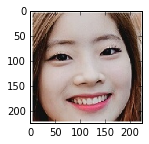

image: 3.jpg, label: Chaeyoung, probs: [[0.36612916 0.27438056 0.3594903 ]]


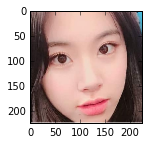

In [31]:
test_model(custom_model4)

This model (freeze 0-16 model) has all 12 images correctly classified

### Comments

-  Like in the referenced website said, it is difficult to find a balance between the number of layers to train and freeze
-  There could be many factors that affect images classification. One of it is image quality. There are some images that look sharp while other images look blurry
-  Number of images used in training and validation also could be the factor since in this experiment I don't have that many images
-  The freeze 0-9 model seems to be good at doing the classification
-  Cannot say much for freeze 0-16 model because sometimes when I tried to run this notebook again it shows signs of going to be overfits